In [13]:
import os
import warnings
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False
    print("Prophet not available; Prophet-based cells will be skipped unless installed.")

warnings.filterwarnings("ignore")


In [14]:
# List available CSV files in the current working directory
from pathlib import Path

for csv_file in Path('.').glob('*.csv'):
    print(csv_file.resolve())

C:\Users\Dell\Desktop\machine learning\restaurant_clients.csv
C:\Users\Dell\Desktop\machine learning\restaurant_daily_factors_sales.csv
C:\Users\Dell\Desktop\machine learning\restaurant_external_factors.csv
C:\Users\Dell\Desktop\machine learning\restaurant_products.csv
C:\Users\Dell\Desktop\machine learning\restaurant_sales_transactions.csv
C:\Users\Dell\Desktop\machine learning\restaurant_stock_inventory.csv


In [3]:
# ============================
# BLOCK 0: Imports & Settings
# ============================

import os
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import Counter, defaultdict

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")


In [15]:
# ============================
# BLOCK 1: Data Loading
# ============================
from pathlib import Path

def safe_save_csv(df, path):
    try:
        df.to_csv(path, index=False)
        print(f"Saved CSV: {path} (rows: {len(df)})")
    except Exception as e:
        print(f"Failed saving CSV {path}: {e}")


def plot_and_save_bar(x, y, title, path, xlabel=None, ylabel=None, rotate=45, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y)
    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha='right')
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    print(f"Saved plot: {path}")


# sklearn availability (define flag correctly)
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    _SKLEARN_AVAILABLE = True
except Exception:
    _SKLEARN_AVAILABLE = False

# -----------------------------
DATA_DIR = Path(".")  # directory containing the CSVs locally
_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

sales_path = DATA_DIR / "restaurant_sales_transactions.csv"
daily_path = DATA_DIR / "restaurant_daily_factors_sales.csv"
stock_path = DATA_DIR / "restaurant_stock_inventory.csv"
clients_path = DATA_DIR / "restaurant_clients.csv"
products_path = DATA_DIR / "restaurant_products.csv"
external_path = DATA_DIR / "restaurant_external_factors.csv"

required_files = [sales_path, daily_path, stock_path, clients_path, products_path, external_path]
for p in required_files:
    if not p.exists():
        raise FileNotFoundError(f"Missing dataset: {p}")

os.makedirs("outputs/plots", exist_ok=True)
os.makedirs("outputs/forecast", exist_ok=True)
os.makedirs("outputs/reports", exist_ok=True)

print(f"Loading data from {DATA_DIR.resolve()}")

sales = pd.read_csv(sales_path, parse_dates=["date", "timestamp"])
daily = pd.read_csv(daily_path, parse_dates=["date"])
stock = pd.read_csv(
    stock_path,
    parse_dates=["arrival_date", "arrival_timestamp", "expiration_date", "expiration_time"],
)
clients = pd.read_csv(clients_path, parse_dates=["first_visit"])
products = pd.read_csv(products_path)
external = pd.read_csv(external_path, parse_dates=["date"])

print("sales.shape   :", sales.shape)
print("daily.shape   :", daily.shape)
print("stock.shape   :", stock.shape)
print("clients.shape :", clients.shape)
print("products.shape:", products.shape)
print("external.shape:", external.shape)


Loading data from C:\Users\Dell\Desktop\machine learning
sales.shape   : (121640, 18)
daily.shape   : (731, 27)
stock.shape   : (2928, 17)
clients.shape : (500, 5)
products.shape: (12, 7)
external.shape: (731, 21)
sales.shape   : (121640, 18)
daily.shape   : (731, 27)
stock.shape   : (2928, 17)
clients.shape : (500, 5)
products.shape: (12, 7)
external.shape: (731, 21)


In [16]:
# ============================
# BLOCK 2: Daily Aggregation
# ============================

# Base daily sales series
daily_sales = (
    sales.groupby("date")
    .agg(
        total_revenue=("total_amount", "sum"),
        total_units=("quantity", "sum"),
        num_transactions=("transaction_id", "nunique"),
    )
    .reset_index()
)

# Attach external factors (already aggregated per day)
daily_ts = daily_sales.merge(
    external[
        [
            "date",
            "temperature",
            "humidity",
            "precipitation",
            "sunshine_hours",
            "wind_speed",
            "weather_condition",
            "is_weekend",
            "event_name",
            "event_type",
            "event_impact_factor",
        ]
    ],
    on="date",
    how="left",
)

daily_ts = daily_ts.sort_values("date").reset_index(drop=True)

print(daily_ts.head())


        date  total_revenue  total_units  num_transactions  temperature  \
0 2023-01-01         5752.0          324               151         13.7   
1 2023-01-02         3159.0          180               150         13.2   
2 2023-01-03         2940.0          175               133         10.5   
3 2023-01-04         4220.0          249               188         15.1   
4 2023-01-05         3479.0          183               130         10.4   

   humidity  precipitation  sunshine_hours  wind_speed weather_condition  \
0      54.0            0.0             1.4         7.0          Overcast   
1      71.0           28.0             2.1        26.4             Rainy   
2      50.0            2.9             0.0         9.1            Cloudy   
3      45.0            3.7             1.8        12.3            Cloudy   
4      61.0            0.0             2.3        16.2          Overcast   

   is_weekend event_name event_type  event_impact_factor  
0           1   New Year    holid

In [17]:

# -----------------------------
# 1. PRECALCULATE REVENUE
# -----------------------------
sales["total_revenue"] = sales["quantity"] * sales["unit_price"]

# -----------------------------
# 2. CONVERT DATE & CREATE MONTH COLUMN
# -----------------------------
sales["date"] = pd.to_datetime(sales["date"])
sales["month"] = sales["date"].dt.to_period("M")  # Year-Month like 2025-11

# -----------------------------
# 3. GROUP BY MONTH + PRODUCT_NAME
# -----------------------------
monthly_products = sales.groupby(["month", "product_name"]).agg(
    units_sold=("quantity", "sum"),
    total_revenue=("total_revenue", "sum")
).reset_index()

# -----------------------------
# 4. CREATE OUTPUT FOLDER
# -----------------------------
os.makedirs("outputs/plots", exist_ok=True)

# -----------------------------
# 5. GET TOP & BOTTOM 5 PER MONTH
# -----------------------------
top5_per_month = monthly_products.groupby("month", group_keys=False).apply(lambda x: x.nlargest(5, "total_revenue"))
bottom5_per_month = monthly_products.groupby("month", group_keys=False).apply(lambda x: x.nsmallest(5, "total_revenue"))

# -----------------------------
# 6. PLOT & SAVE
# -----------------------------
for month in monthly_products["month"].unique():
    top5 = top5_per_month[top5_per_month["month"] == month]
    bottom5 = bottom5_per_month[bottom5_per_month["month"] == month]

    # --- Top 5 ---
    plt.figure(figsize=(10, 5))
    plt.bar(top5["product_name"], top5["total_revenue"], color="green")
    plt.xticks(rotation=45)
    plt.title(f"Top 5 Products - {month}")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.savefig(f"outputs/plots/top_{month}.png")
    plt.close()

    # --- Bottom 5 ---
    plt.figure(figsize=(10, 5))
    plt.bar(bottom5["product_name"], bottom5["total_revenue"], color="red")
    plt.xticks(rotation=45)
    plt.title(f"Bottom 5 Products - {month}")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.savefig(f"outputs/plots/bottom_{month}.png")
    plt.close()

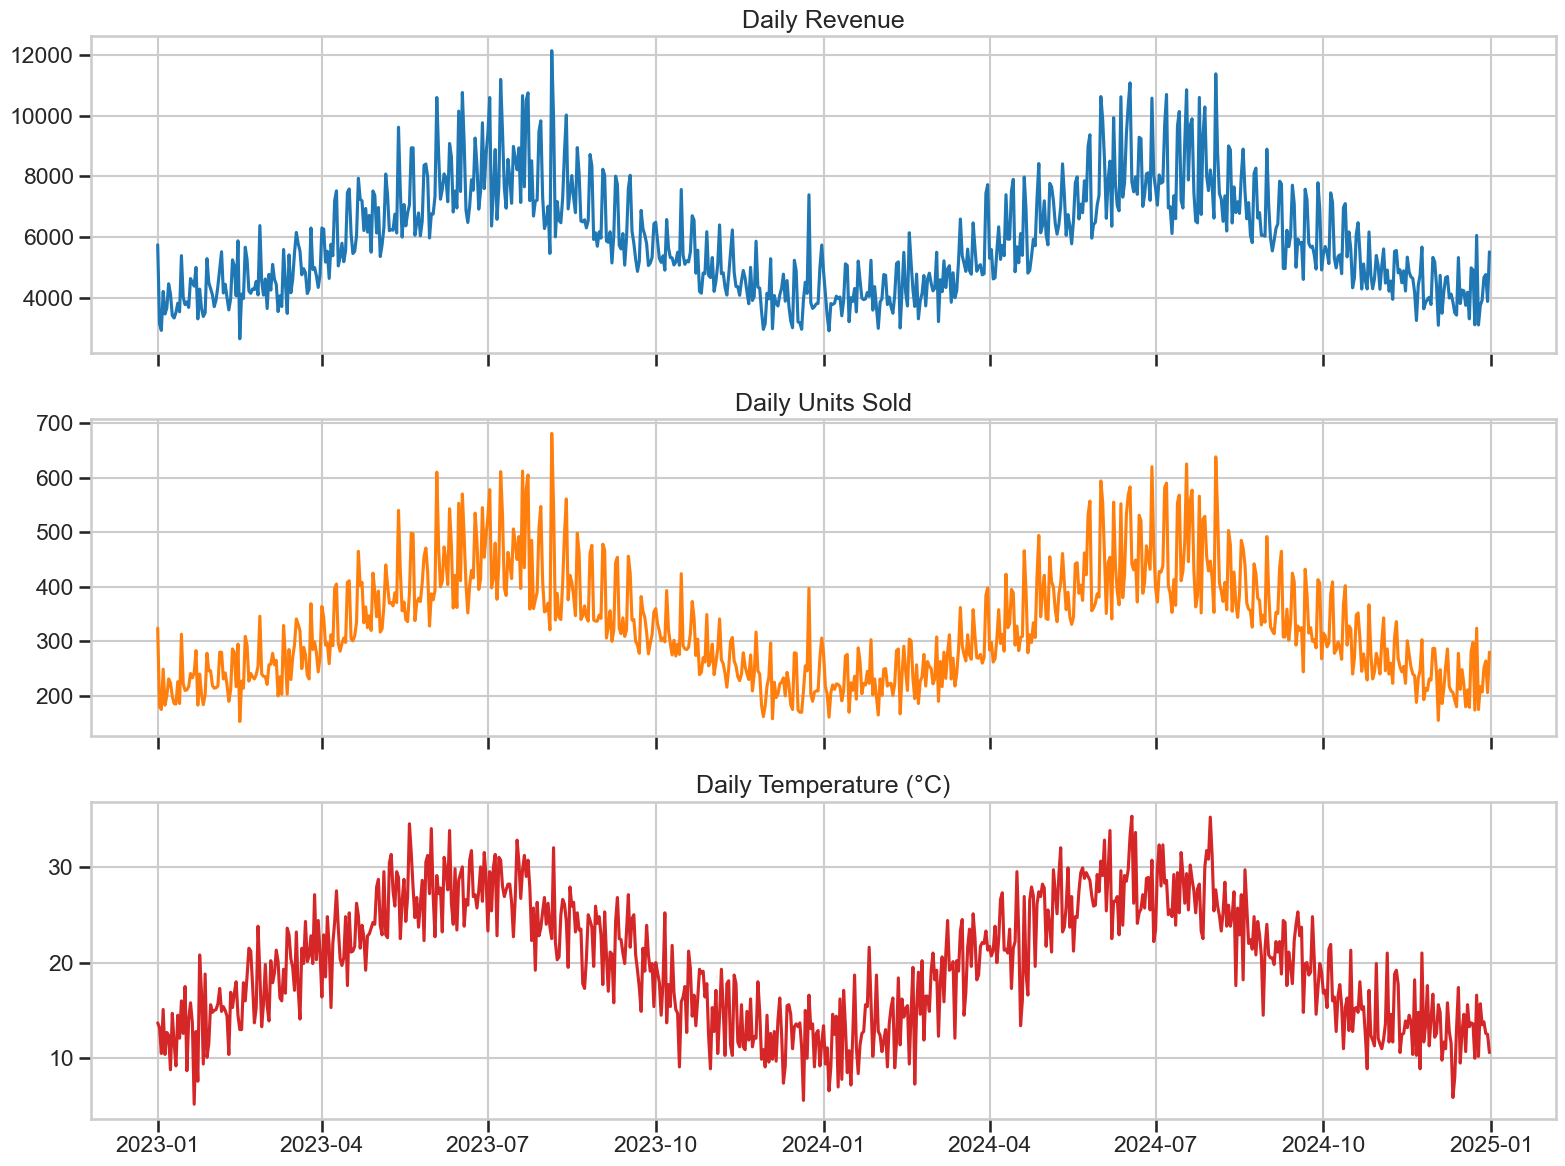

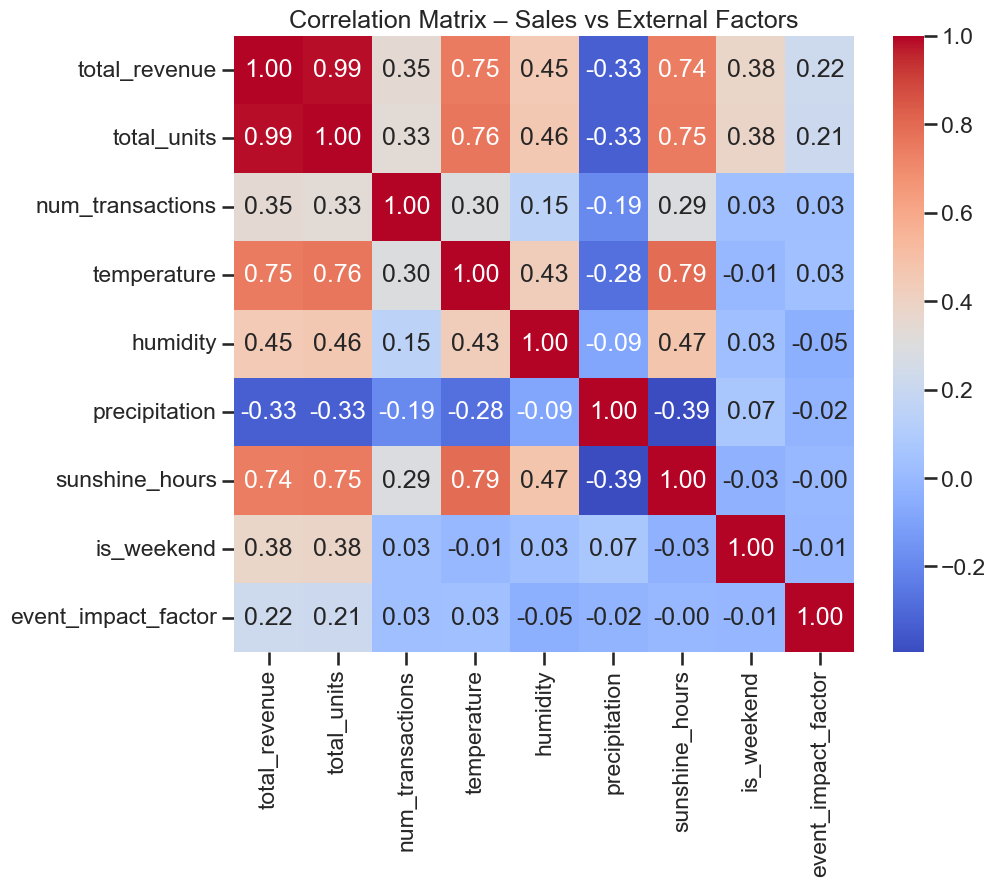

In [18]:
# ============================
# BLOCK 3: Quick EDA
# ============================

os.makedirs("outputs/plots", exist_ok=True)

# ---------------------------------------
# 1. DAILY TRENDS (Revenue, Units, Temp)
# ---------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(daily_ts["date"], daily_ts["total_revenue"])
axes[0].set_title("Daily Revenue")

axes[1].plot(daily_ts["date"], daily_ts["total_units"], color="tab:orange")
axes[1].set_title("Daily Units Sold")

axes[2].plot(daily_ts["date"], daily_ts["temperature"], color="tab:red")
axes[2].set_title("Daily Temperature (°C)")

for ax in axes:
    ax.set_xlabel("")

plt.tight_layout()

# SAVE FIRST ➜ THEN SHOW
plt.savefig("outputs/plots/EDA_daily_trends.png")
plt.show()


# ---------------------------------------
# 2. CORRELATION MAP
# ---------------------------------------

corr_cols = [
    "total_revenue",
    "total_units",
    "num_transactions",
    "temperature",
    "humidity",
    "precipitation",
    "sunshine_hours",
    "is_weekend",
    "event_impact_factor",
]

corr = daily_ts[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Sales vs External Factors")

# SAVE FIRST ➜ THEN SHOW
plt.savefig("outputs/plots/correlation_map.png")
plt.show()


=== Advanced Time Series Forecasting ===
Using Enhanced ETS with External Regressors (Prophet alternative)

Advanced Forecast Results:
RMSE: 47.27
MAPE: 15.48%
R²: -0.264


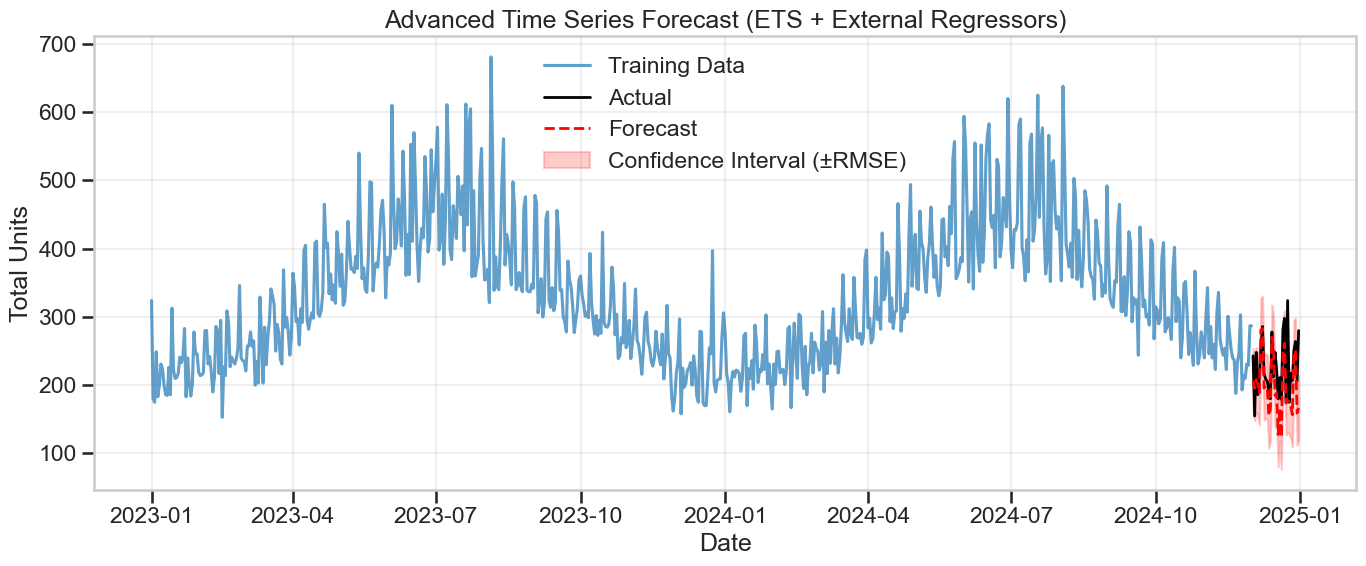

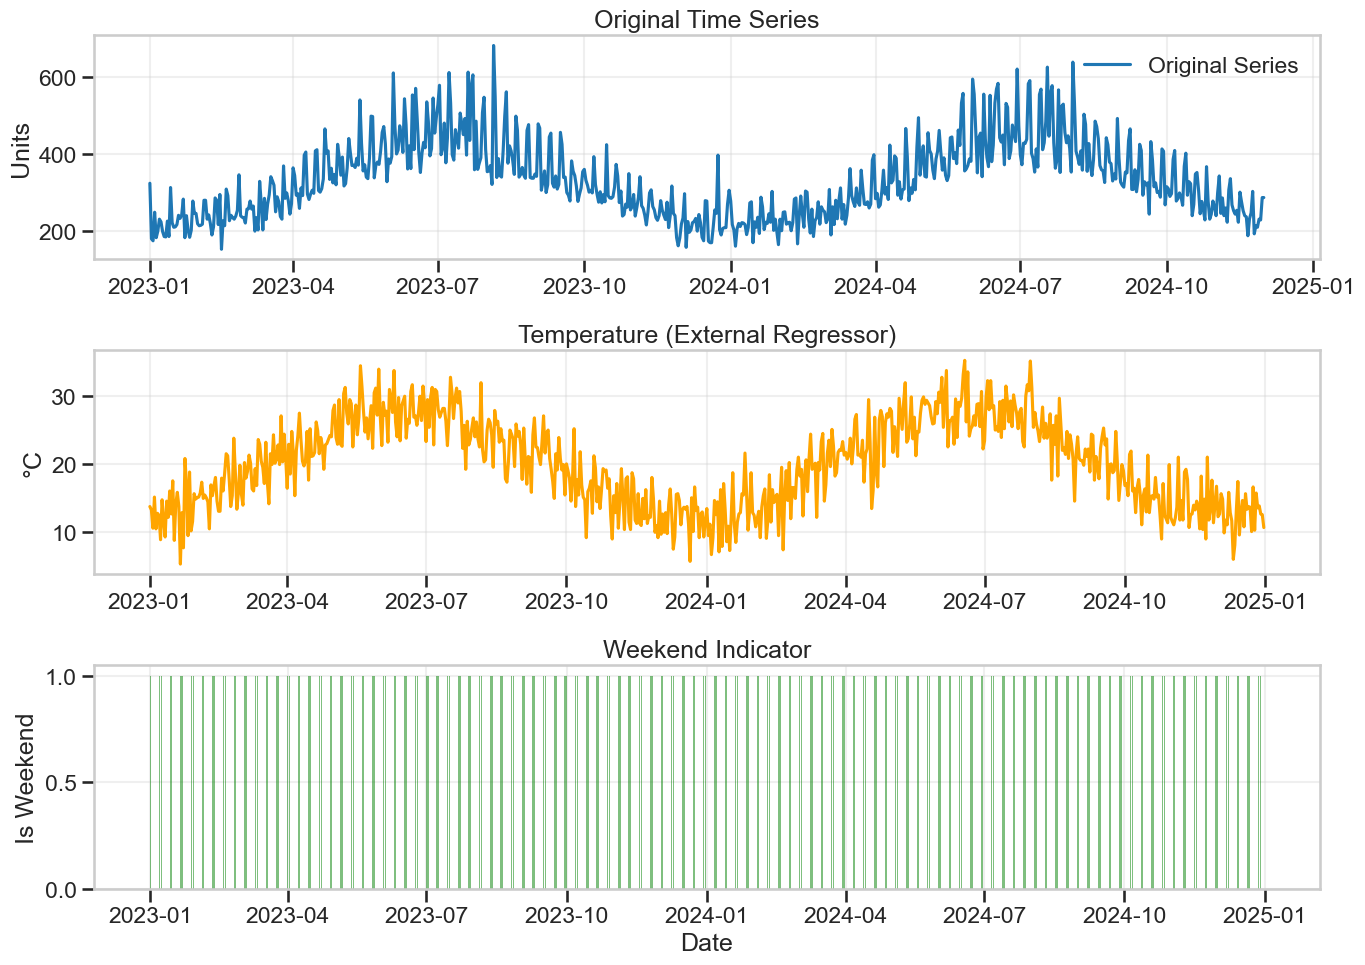


✓ Forecast plots saved to outputs/plots/


In [19]:
# ============================
# BLOCK: Advanced Time Series Forecast (Prophet Alternative)
# ============================
# Using enhanced ETS with external regressors as Prophet replacement
# This provides similar functionality without Stan backend issues

print("=== Advanced Time Series Forecasting ===")
print("Using Enhanced ETS with External Regressors (Prophet alternative)")

# Configuration
FORECAST_HORIZON = 30
USE_EXTERNAL_REGRESSORS = True

# Prepare data
forecast_df = daily_ts[["date", "total_units", "temperature", "precipitation", "is_weekend"]].copy()
forecast_df["date"] = pd.to_datetime(forecast_df["date"])
forecast_df = forecast_df.sort_values("date").reset_index(drop=True)

# Train/test split
train_data = forecast_df.iloc[:-FORECAST_HORIZON].copy()
test_data = forecast_df.iloc[-FORECAST_HORIZON:].copy()

# Method 1: ETS with seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

y_train = train_data["total_units"].values
y_test = test_data["total_units"].values

# Fit ETS model
ets_model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=7,
    initialization_method="estimated"
).fit()

ets_forecast = ets_model.forecast(FORECAST_HORIZON)

# Method 2: Add external regressor adjustment
if USE_EXTERNAL_REGRESSORS:
    # Train a simple linear model for weather effects
    X_train = train_data[["temperature", "precipitation", "is_weekend"]].fillna(0).values
    X_test = test_data[["temperature", "precipitation", "is_weekend"]].fillna(0).values
    
    # Get residuals from ETS
    ets_fitted = ets_model.fittedvalues
    residuals = y_train[len(y_train)-len(ets_fitted):] - ets_fitted
    
    # Fit regressor on residuals
    from sklearn.linear_model import Ridge
    regressor = Ridge(alpha=1.0)
    regressor.fit(X_train[len(X_train)-len(residuals):], residuals)
    
    # Adjust forecast with external factors
    adjustment = regressor.predict(X_test)
    final_forecast = ets_forecast + adjustment
else:
    final_forecast = ets_forecast

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, final_forecast))
mape = mean_absolute_percentage_error(y_test, final_forecast) * 100
r2 = r2_score(y_test, final_forecast)

print(f"\nAdvanced Forecast Results:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(train_data["date"], y_train, label="Training Data", alpha=0.7)
plt.plot(test_data["date"], y_test, label="Actual", color="black", linewidth=2)
plt.plot(test_data["date"], final_forecast, label="Forecast", color="red", linewidth=2, linestyle="--")
plt.fill_between(
    test_data["date"],
    final_forecast - rmse,
    final_forecast + rmse,
    alpha=0.2,
    color="red",
    label="Confidence Interval (±RMSE)"
)
plt.title("Advanced Time Series Forecast (ETS + External Regressors)")
plt.xlabel("Date")
plt.ylabel("Total Units")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/plots/advanced_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

# Components plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Trend
axes[0].plot(train_data["date"], y_train, label="Original Series")
axes[0].set_title("Original Time Series")
axes[0].set_ylabel("Units")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Temperature effect
axes[1].plot(forecast_df["date"], forecast_df["temperature"], color="orange")
axes[1].set_title("Temperature (External Regressor)")
axes[1].set_ylabel("°C")
axes[1].grid(True, alpha=0.3)

# Weekend effect
axes[2].bar(forecast_df["date"], forecast_df["is_weekend"], color="green", alpha=0.5)
axes[2].set_title("Weekend Indicator")
axes[2].set_ylabel("Is Weekend")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/plots/forecast_components.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Forecast plots saved to outputs/plots/")

# --- Legacy Prophet code (kept for reference, not executed) ---
if False:
    import numpy as np
    import pandas as pd
    from prophet import Prophet
    from prophet.diagnostics import cross_validation, performance_metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
    import matplotlib.pyplot as plt

    # ---------------- Config ----------------
    FORECAST_HORIZON = 30
    USE_LOG_TRANSFORM = True  # set to False if you want to work on the raw scale

    # Prepare Prophet dataframe (using daily_ts created earlier)
    prophet_df = daily_ts.rename(columns={"date": "ds", "total_units": "y"})
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

    # Detect available regressors
    has_temp = "temperature" in prophet_df.columns
    has_prec = "precipitation" in prophet_df.columns

    cols = ["ds", "y"]
    if has_temp:
        cols.append("temperature")
    if has_prec:
        cols.append("precipitation")

    # Deterministic regressor: weekend flag
    prophet_df["is_weekend"] = prophet_df["ds"].dt.weekday >= 5
    cols.append("is_weekend")

    prophet_df = prophet_df[cols].sort_values("ds").reset_index(drop=True)

    # Sanity check
    assert prophet_df["y"].notnull().all(), "Null values found in y — handle them before modeling."

    # Optional log transform
    if USE_LOG_TRANSFORM:
        prophet_df["y_orig"] = prophet_df["y"]
        prophet_df["y"] = np.log1p(prophet_df["y"])

    # ---------------- Model definition ----------------
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,
    )
    m.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    # Add regressors if present
    if has_temp:
        m.add_regressor("temperature", standardize=True)
    if has_prec:
        m.add_regressor("precipitation", standardize=True)
    m.add_regressor("is_weekend", standardize=False)

    # ---------------- Train / Test split ----------------
    train = prophet_df.iloc[:-FORECAST_HORIZON].copy()
    test = prophet_df.iloc[-FORECAST_HORIZON:].copy()

    m.fit(train)

    # ---------------- Future dataframe ----------------
    future = m.make_future_dataframe(periods=FORECAST_HORIZON)
    future["ds"] = pd.to_datetime(future["ds"])

    # Merge historical regressors
    reg_cols = [c for c in ["temperature", "precipitation", "is_weekend"] if c in prophet_df.columns]
    future = future.merge(prophet_df[["ds"] + reg_cols], on="ds", how="left")

    # Deterministic weekend recomputation
    if "is_weekend" in reg_cols:
        future["is_weekend"] = future["ds"].dt.weekday >= 5

    # Helper: impute unknown future weather with day‑of‑year means
    def impute_with_doy_mean(df_hist, future_df, col):
        tmp = df_hist[["ds", col]].copy()
        tmp["doy"] = tmp["ds"].dt.dayofyear
        doy_mean = tmp.groupby("doy")[col].mean()

        future_df["doy"] = future_df["ds"].dt.dayofyear
        future_df[col] = future_df[col].fillna(future_df["doy"].map(doy_mean))
        future_df[col] = future_df[col].fillna(df_hist[col].median())
        future_df.drop(columns=["doy"], inplace=True)
        return future_df

    if has_temp:
        future = impute_with_doy_mean(prophet_df, future, "temperature")
    if has_prec:
        future = impute_with_doy_mean(prophet_df, future, "precipitation")

    # Final NaN check
    req_regs = []
    if has_temp:
        req_regs.append("temperature")
    if has_prec:
        req_regs.append("precipitation")
    req_regs.append("is_weekend")
    assert future[req_regs].notnull().all().all(), "Some regressors still contain NaNs — fix imputation."

    # ---------------- Forecast & evaluation ----------------
    forecast = m.predict(future)

    fcst_tail = forecast.tail(FORECAST_HORIZON).reset_index(drop=True)
    y_true = test["y"].values
    y_pred = fcst_tail["yhat"].values

    if USE_LOG_TRANSFORM:
        y_true_inv = np.expm1(y_true)
        y_pred_inv = np.expm1(y_pred)
    else:
        y_true_inv = y_true
        y_pred_inv = y_pred

    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv) * 100
    r2 = r2_score(y_true_inv, y_pred_inv)

    print(f"Prophet – RMSE: {rmse:,.2f}, MAPE: {mape:,.2f}%, R²: {r2:.3f}")

    # Plots
    fig1 = m.plot(forecast)
    plt.title("Prophet – Daily Units Forecast")
    plt.savefig("outputs/plots/prophet_forecast.png", bbox_inches="tight")
    plt.show()

    fig2 = m.plot_components(forecast)
    plt.savefig("outputs/plots/prophet_components.png", bbox_inches="tight")
    plt.show()

    # Residuals on horizon
    resid = y_true_inv - y_pred_inv
    plt.figure(figsize=(10, 4))
    plt.plot(test["ds"], resid, marker="o", linestyle="-")
    plt.axhline(0, color="k", linewidth=0.7)
    plt.title("Prophet Residuals (Forecast Horizon)")
    plt.tight_layout()
    plt.savefig("outputs/plots/prophet_residuals.png", bbox_inches="tight")
    plt.show()


Daily Revenue – Forecast Evaluation (30-day horizon)
Baseline_Mean   | RMSE:    96.71 | MAPE:  38.74% | R²: -2.915
ETS             | RMSE:    38.30 | MAPE:  11.16% | R²:  0.386


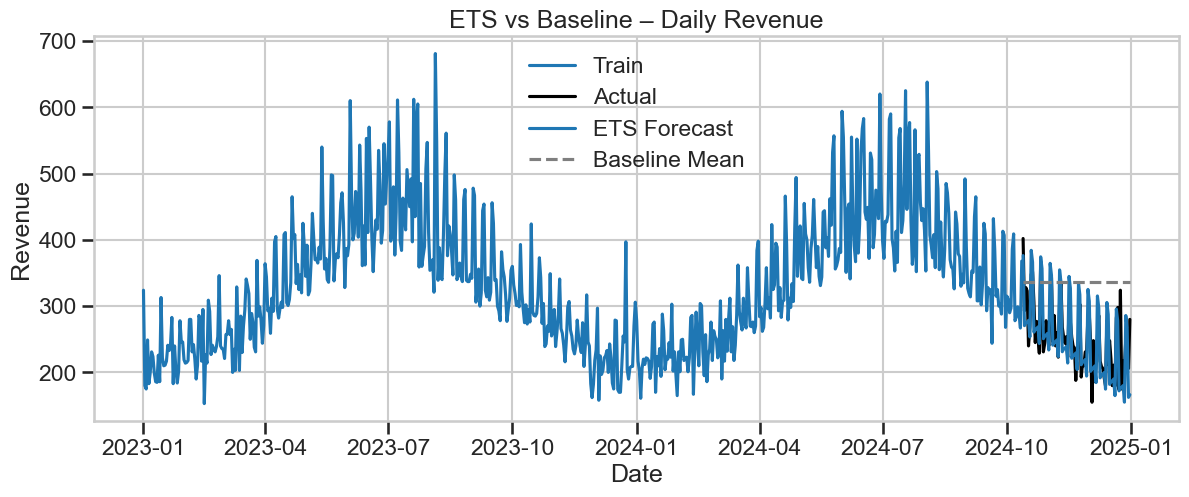

In [20]:
# ============================
# BLOCK 5: Baseline & ETS
# ============================

y = daily_ts["total_units"].values
train_size = len(y) - 80
y_train, y_test = y[:train_size], y[train_size:]
dates_train = daily_ts["date"].iloc[:train_size]
dates_test = daily_ts["date"].iloc[train_size:]

# Baseline: mean of train
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

ets_model = ExponentialSmoothing(
    y_train, trend="add", seasonal="add", seasonal_periods=7
).fit()
ets_pred = ets_model.forecast(len(y_test))

def evaluate_model(name, y_true, y_hat):
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = mean_absolute_percentage_error(y_true, y_hat) * 100
    r2 = r2_score(y_true, y_hat)
    print(f"{name:15s} | RMSE: {rmse:8.2f} | MAPE: {mape:6.2f}% | R²: {r2:6.3f}")
    return rmse, mape, r2

print("Daily Revenue – Forecast Evaluation (30-day horizon)")
eval_baseline = evaluate_model("Baseline_Mean", y_test, baseline_pred)
eval_ets = evaluate_model("ETS", y_test, ets_pred)

plt.figure(figsize=(14, 5))
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_test, y_test, label="Actual", color="black")
plt.plot(dates_test, ets_pred, label="ETS Forecast", color="tab:blue")
plt.plot(dates_test, baseline_pred, label="Baseline Mean", color="tab:gray", linestyle="--")
plt.legend()
plt.title("ETS vs Baseline – Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


RandomForest    | RMSE:    30.25 | MAPE:  10.36% | R²:  0.483


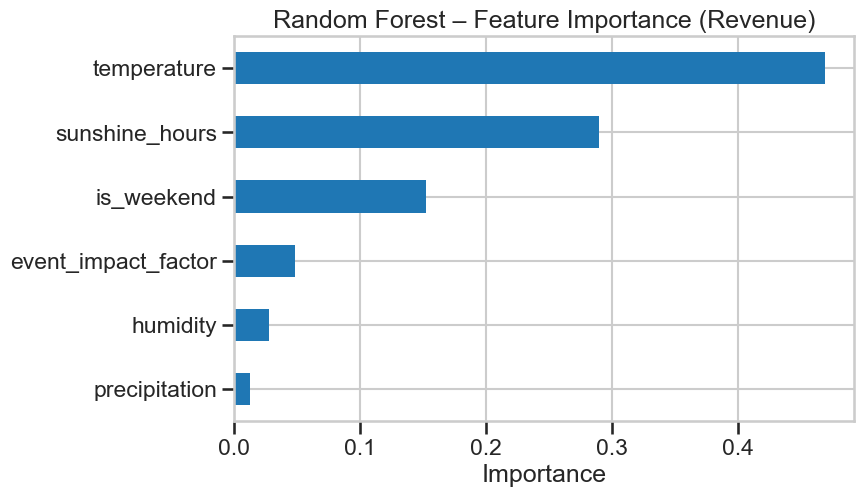

In [21]:
# ============================
# BLOCK 6: Random Forest Regressor
# ============================

feature_cols = [
    "temperature",
    "humidity",
    "precipitation",
    "sunshine_hours",
    "is_weekend",
    "event_impact_factor",
]

X = daily_ts[feature_cols]
y = daily_ts["total_units"]

split_idx = len(daily_ts) - 30
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse, mape, r2 = evaluate_model("RandomForest", y_test.values, y_pred)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()

plt.figure(figsize=(8, 5))
importances.plot(kind="barh")
plt.title("Random Forest – Feature Importance (Revenue)")
plt.xlabel("Importance")
plt.show()


✓ CSV exported: outputs/forecast/near_expiry_products.csv

Top products at expiry risk (by quantity):
product_name
Lobster Tail    9528
Name: quantity_received, dtype: int64


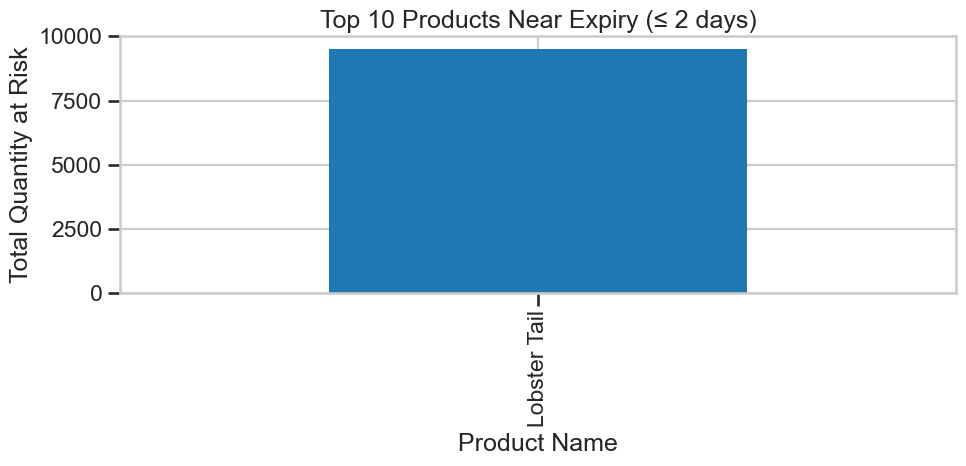

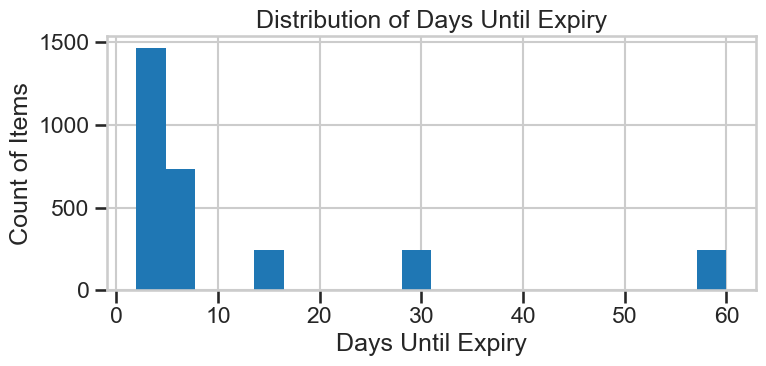

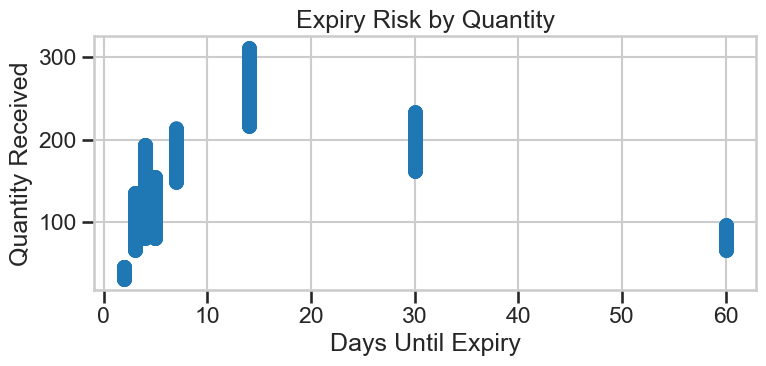

In [22]:
# ============================
# BLOCK 7: Inventory & Expiry
# ============================

import matplotlib.pyplot as plt
import pandas as pd

# Calculate number of days until expiry
stock["days_until_expiry_calc"] = (
    (stock["expiration_date"] - stock["arrival_date"]).dt.days
)

# Filter products expiring within the next 2 days
near_expiry = stock[stock["days_until_expiry_calc"] <= 2]

# --- Save full list to CSV ---
output_path = "outputs/forecast/near_expiry_products.csv"
near_expiry.to_csv(output_path, index=False)
print(f"✓ CSV exported: {output_path}")

# --- Summary group ---
summary_near_expiry = (
    near_expiry.groupby("product_name")["quantity_received"]
    .sum()
    .sort_values(ascending=False)
)

print("\nTop products at expiry risk (by quantity):")
print(summary_near_expiry.head(10))


# ============================
# PLOTTING
# ============================

# --- 1) Bar plot of top 10 products at expiry risk ---
plt.figure(figsize=(10, 5))
summary_near_expiry.head(10).plot(kind="bar")
plt.title("Top 10 Products Near Expiry (≤ 2 days)")
plt.xlabel("Product Name")
plt.ylabel("Total Quantity at Risk")
plt.tight_layout()
plt.savefig("outputs/plots/10_prods_near_exp.png")
plt.show()


# --- 2) Histogram of days until expiry ---
plt.figure(figsize=(8, 4))
plt.hist(stock["days_until_expiry_calc"], bins=20)
plt.title("Distribution of Days Until Expiry")
plt.xlabel("Days Until Expiry")
plt.ylabel("Count of Items")
plt.tight_layout()
plt.savefig("outputs/plots/days_until_exp.png")
plt.show()


# --- 3) Scatter: days_until_expiry vs quantity_received ---
plt.figure(figsize=(8, 4))
plt.scatter(stock["days_until_expiry_calc"], stock["quantity_received"])
plt.title("Expiry Risk by Quantity")
plt.xlabel("Days Until Expiry")
plt.ylabel("Quantity Received")
plt.tight_layout()
plt.savefig("outputs/plots/exp_days_vs_quant")
plt.show()


In [23]:

# -----------------------------
# 1) RISK PRODUCTS & DISCOUNT STRATEGY
# -----------------------------
print("\n--- Commercial Strategy: Risk products & discounts ---")

# Ensure stock exists
if 'stock' not in globals():
    print("⚠️  `stock` not found in the environment. Skipping risk computation.")
    risk_products = pd.DataFrame(columns=["product_name","final_stock","near_expiry_qty","near_expiry_ratio"])
else:
    # Ensure quantity column detection for stock
    qty_col = None
    for c in ["quantity_received", "quantity", "final_stock", "qty"]:
        if c in stock.columns:
            qty_col = c
            break

    if qty_col is None:
        print("⚠️  No quantity column found in stock (expected 'quantity_received' or 'quantity'). Skipping risk computation.")
        risk_products = pd.DataFrame(columns=["product_name","final_stock","near_expiry_qty","near_expiry_ratio"])
    else:
        inv = stock.copy()
        # ensure arrival/expiration are datetime
        if "arrival_date" in inv.columns:
            inv["arrival_date"] = pd.to_datetime(inv["arrival_date"], errors="coerce")
        if "expiration_date" in inv.columns:
            inv["expiration_date"] = pd.to_datetime(inv["expiration_date"], errors="coerce")

        # ensure days_until_expiry_calc exists (Block 7 already computed)
        if "days_until_expiry_calc" not in inv.columns:
            inv["days_until_expiry_calc"] = ((inv["expiration_date"] - inv["arrival_date"]).dt.days).fillna(9999).astype(int)

        # compute near expiry qty (<= 2 days as earlier), adjustable window
        near_window = 2
        inv["near_expiry_qty"] = np.where(inv["days_until_expiry_calc"] <= near_window, inv[qty_col].fillna(0), 0)

        inv_group = inv.groupby("product_name").agg(
            final_stock=(qty_col, "sum"),
            near_expiry_qty=("near_expiry_qty", "sum")
        ).reset_index()

        inv_group["final_stock"] = inv_group["final_stock"].fillna(0)
        inv_group["near_expiry_qty"] = inv_group["near_expiry_qty"].fillna(0)
        inv_group["near_expiry_ratio"] = inv_group["near_expiry_qty"] / inv_group["final_stock"].replace({0: np.nan})
        inv_group["near_expiry_ratio"] = inv_group["near_expiry_ratio"].fillna(0)

        # Score = weighted combination of ratio and absolute qty
        ratio_norm = inv_group["near_expiry_ratio"]
        qty_norm = (inv_group["near_expiry_qty"] - inv_group["near_expiry_qty"].min())
        if qty_norm.max() > 0:
            qty_norm = qty_norm / qty_norm.max()
        else:
            qty_norm = qty_norm * 0.0
        inv_group["expiry_risk_score"] = 0.7 * ratio_norm + 0.3 * qty_norm

        threshold_ratio = 0.2
        risk_products = inv_group[
            (inv_group["near_expiry_ratio"] >= threshold_ratio) |
            (inv_group["expiry_risk_score"] >= inv_group["expiry_risk_score"].quantile(0.9))
        ].copy()

        risk_products = risk_products.sort_values(["expiry_risk_score", "near_expiry_ratio"], ascending=False)

# discount recommendation logic
def recommend_discount(row):
    r = float(row.get("near_expiry_ratio", 0) or 0)
    q = float(row.get("near_expiry_qty", 0) or 0)
    # base percent by ratio
    if r >= 0.7:
        base = 60
    elif r >= 0.5:
        base = 40
    elif r >= 0.3:
        base = 25
    elif r >= 0.2:
        base = 15
    else:
        base = 10
    # boost for large absolute quantity
    if q >= 100:
        base += 15
    elif q >= 50:
        base += 7
    base = min(80, base)
    return int(5 * round(base / 5))

if not risk_products.empty:
    risk_products["recommended_discount_pct"] = risk_products.apply(recommend_discount, axis=1)
    safe_save_csv(risk_products, f"outputs/plots/discount_recommendations_{_ts}.csv")
    # plot top risk products
    try:
        top_plot = risk_products.sort_values("expiry_risk_score", ascending=False).head(15)
        plot_and_save_bar(top_plot["product_name"], top_plot["expiry_risk_score"],
                          "Top Near-Expiry Products (risk score)", f"outputs/plots/near_expiry_risk_{_ts}.png",
                          xlabel="Product", ylabel="Expiry risk score")
    except Exception as e:
        print("⚠️ Plotting risk products failed:", e)
else:
    print("No risk products identified (empty set).")

# -----------------------------
# 2) BUNDLE SUGGESTIONS (market-basket + fallback)
# -----------------------------
print("\n--- Commercial Strategy: Bundles (market-basket + fallback) ---")

# prefer a transaction/order id column
txn_col = None
if 'sales' in globals():
    for c in ["transaction_id", "order_id", "ticket_id", "receipt_id"]:
        if c in sales.columns:
            txn_col = c
            break

bundles_df = pd.DataFrame()
if txn_col is not None and "product_name" in sales.columns:
    trans_products = sales.groupby(txn_col)["product_name"].apply(lambda x: list(x.dropna().astype(str))).reset_index()
    pair_counter = Counter()
    for prod_list in trans_products["product_name"]:
        uniq = list(set(prod_list))
        if len(uniq) < 2:
            continue
        for a, b in itertools.combinations(sorted(uniq), 2):
            pair_counter[(a, b)] += 1

    pairs = [{"product_a": a, "product_b": b, "co_count": c} for (a, b), c in pair_counter.items()]
    if pairs:
        pairs_df = pd.DataFrame(pairs).sort_values("co_count", ascending=False)
        prod_counts = sales["product_name"].value_counts().to_dict()
        pairs_df["score"] = pairs_df["co_count"] * 0.6 + pairs_df["product_a"].map(prod_counts) * 0.2 + pairs_df["product_b"].map(prod_counts) * 0.2
        bundles_df = pairs_df.head(50).copy()
        safe_save_csv(bundles_df, f"outputs/plots/bundles_copurchase_{_ts}.csv")
        bundle_suggestions = bundles_df.head(15).apply(lambda r: {"bundle": f"{r['product_a']} + {r['product_b']}", "score": r["score"], "co_count": r["co_count"]}, axis=1)
        bundle_suggestions = pd.DataFrame(list(bundle_suggestions))
        safe_save_csv(bundle_suggestions, f"outputs/plots/bundle_suggestions_{_ts}.csv")
        try:
            top_pairs = bundles_df.head(10).copy()
            top_pairs["label"] = top_pairs["product_a"] + " + " + top_pairs["product_b"]
            plot_and_save_bar(top_pairs["label"], top_pairs["co_count"], "Top Co-purchased Pairs", f"outputs/plots/top_copurchase_pairs_{_ts}.png", xlabel="Pair", ylabel="Co-purchase count")
        except Exception as e:
            print("⚠️ Bundle plotting failed:", e)
    else:
        print("No co-purchase pairs found (maybe transactions have <=1 product each).")
else:
    print("No transaction/order id or product_name in sales — falling back to top-seller pairing.")
    if 'sales' in globals() and "product_name" in sales.columns:
        sales_agg = sales.groupby("product_name").agg(units_sold=("quantity","sum") if "quantity" in sales.columns else ("product_name","count")).reset_index()
        sales_agg = sales_agg.sort_values("units_sold", ascending=False).head(20).reset_index(drop=True)
        fallback_pairs = []
        for i in range(min(10, len(sales_agg))):
            a = sales_agg.loc[i, "product_name"]
            b = sales_agg.loc[i+1, "product_name"] if i+1 < len(sales_agg) else a
            fallback_pairs.append({"product_a": a, "product_b": b, "co_count": None})
        bundles_df = pd.DataFrame(fallback_pairs)
        safe_save_csv(bundles_df, f"outputs/plots/bundles_fallback_{_ts}.csv")
    else:
        print("⚠️ sales or product_name missing — cannot produce bundles.")

# -----------------------------
# 3) RFM CUSTOMER SEGMENTATION & OFFER MAPPING
# -----------------------------
print("\n--- Commercial Strategy: Customer segmentation (RFM) ---")

rfm_df = pd.DataFrame()
if 'sales' in globals() and "client_id" in sales.columns:
    order_col = "order_id" if "order_id" in sales.columns else ("transaction_id" if "transaction_id" in sales.columns else None)
    monetary_col = "total_revenue" if "total_revenue" in sales.columns else ("total_amount" if "total_amount" in sales.columns else None)

    if monetary_col is None:
        print("⚠️  No monetary column found in sales ('total_revenue' or 'total_amount'). Skipping RFM.")
    else:
        TODAY = sales["date"].max() if "date" in sales.columns else pd.Timestamp.today()
        agg_map = {
            "recency": ("date", lambda x: (TODAY - x.max()).days if x.notnull().any() else np.nan),
            "frequency": (order_col, "nunique") if order_col is not None else ("client_id", "count"),
            "monetary": (monetary_col, "sum")
        }
        try:
            rfm_df = sales.groupby("client_id").agg(**agg_map).reset_index()
            rfm_df[["recency","frequency","monetary"]] = rfm_df[["recency","frequency","monetary"]].fillna(0)

            if _SKLEARN_AVAILABLE:
                scaler = StandardScaler()
                rfm_scaled_all = scaler.fit_transform(rfm_df[["recency","frequency","monetary"]])
                best_k = 4
                best_score = -1
                max_k = min(6, max(2, len(rfm_df)//10))
                for k in range(2, max_k+1):
                    try:
                        km = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled_all)
                        score = silhouette_score(rfm_scaled_all, km.labels_)
                        if score > best_score:
                            best_score = score
                            best_k = k
                    except Exception:
                        continue
                kmeans = KMeans(n_clusters=best_k, random_state=42).fit(rfm_scaled_all)
                rfm_df["cluster"] = kmeans.labels_
                print(f"RFM clustering: selected k={best_k} (silhouette={best_score:.3f})")
            else:
                rfm_df["cluster"] = pd.qcut(rfm_df["monetary"].rank(method="first"), 4, labels=False)
                print("sklearn not available — used monetary quantiles for clustering.")

            cluster_map = {0: "VIP offer", 1: "bundle promo", 2: "discount", 3: "standard"}
            max_cluster = int(rfm_df["cluster"].max())
            for c in range(max_cluster + 1):
                if c not in cluster_map:
                    cluster_map[c] = "standard"
            rfm_df["offer_type"] = rfm_df["cluster"].map(cluster_map)
            safe_save_csv(rfm_df, f"outputs/plots/upsell_crosssell_rfm_{_ts}.csv")

            try:
                plt.figure(figsize=(6,4))
                sns.countplot(x="cluster", data=rfm_df)
                plt.title("RFM Cluster distribution")
                plt.tight_layout()
                plt.savefig(f"outputs/plots/rfm_cluster_distribution_{_ts}.png")
                plt.close()
                print(f"✓ Saved plot: outputs/plots/rfm_cluster_distribution_{_ts}.png")
            except Exception as e:
                print("⚠️ RFM cluster plotting failed:", e)
        except Exception as e:
            print("⚠️ RFM computation failed:", e)
else:
    print("⚠️ No 'client_id' in sales — skipping RFM segmentation.")

# -----------------------------
# 4) MONTHLY COMMERCIAL SUMMARY (CSV)
# -----------------------------
print("\n--- Commercial Strategy: Monthly commercial summary ---")
report_path = None
try:
    if 'sales' not in globals():
        raise RuntimeError("`sales` dataset not available")

    if "month" not in sales.columns:
        sales["month"] = pd.to_datetime(sales["date"]).dt.to_period("M").astype(str)

    monthly_prod = sales.groupby(["month", "product_name"]).agg(
        units_sold=("quantity","sum") if "quantity" in sales.columns else ("product_name","count"),
        revenue=("total_revenue","sum") if "total_revenue" in sales.columns else ("total_amount","sum")
    ).reset_index()

    monthly_top5 = monthly_prod.sort_values(["month","revenue"], ascending=[True,False]).groupby("month").head(5).reset_index(drop=True)
    monthly_top5["rank"] = monthly_top5.groupby("month")["revenue"].rank(method="first", ascending=False).astype(int)

    if not risk_products.empty:
        rpt = risk_products[["product_name","near_expiry_qty","near_expiry_ratio","recommended_discount_pct"]].copy()
        monthly_top5 = monthly_top5.merge(rpt, on="product_name", how="left")

    report_path = f"outputs/reports/monthly_commercial_summary_{_ts}.csv"
    safe_save_csv(monthly_top5, report_path)
except Exception as e:
    print("✖ Failed generating monthly summary:", e)

# -----------------------------
# SUMMARY PRINTS
# -----------------------------
print("\n--- Commercial Strategy summary ---")
print(f"Risk product rows: {len(risk_products) if 'risk_products' in locals() else 0}")
print(f"Bundle rows (pairs or fallback): {len(bundles_df) if 'bundles_df' in locals() else 0}")
print(f"RFM rows: {len(rfm_df) if 'rfm_df' in locals() else 0}")
print(f"Monthly summary saved at: {report_path if report_path is not None else 'n/a'}")
print("All outputs (CSV/PNG) are in outputs/plots/ and outputs/reports/")



--- Commercial Strategy: Risk products & discounts ---
Saved CSV: outputs/plots/discount_recommendations_20251209_171046.csv (rows: 12)
Saved plot: outputs/plots/near_expiry_risk_20251209_171046.png

--- Commercial Strategy: Bundles (market-basket + fallback) ---
No co-purchase pairs found (maybe transactions have <=1 product each).

--- Commercial Strategy: Customer segmentation (RFM) ---
RFM clustering: selected k=3 (silhouette=0.366)
Saved CSV: outputs/plots/upsell_crosssell_rfm_20251209_171046.csv (rows: 500)
No co-purchase pairs found (maybe transactions have <=1 product each).

--- Commercial Strategy: Customer segmentation (RFM) ---
RFM clustering: selected k=3 (silhouette=0.366)
Saved CSV: outputs/plots/upsell_crosssell_rfm_20251209_171046.csv (rows: 500)


  File "c:\Users\Dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Dell\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\anaconda3\Lib\subprocess.py",

✓ Saved plot: outputs/plots/rfm_cluster_distribution_20251209_171046.png

--- Commercial Strategy: Monthly commercial summary ---
Saved CSV: outputs/reports/monthly_commercial_summary_20251209_171046.csv (rows: 120)

--- Commercial Strategy summary ---
Risk product rows: 12
Bundle rows (pairs or fallback): 0
RFM rows: 500
Monthly summary saved at: outputs/reports/monthly_commercial_summary_20251209_171046.csv
All outputs (CSV/PNG) are in outputs/plots/ and outputs/reports/


In [25]:
# -----------------------------
# DEMAND FORECAST + REORDER RECOMMENDATIONS (per product, per month/week)
# -----------------------------
import os
import datetime as dt
from collections import defaultdict
import numpy as np
import pandas as pd

_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("outputs/plots", exist_ok=True)
os.makedirs("outputs/reports", exist_ok=True)

# try imports
try:
    from prophet import Prophet
    _PROPHET_OK = True
except Exception:
    _PROPHET_OK = False

try:
    from scipy.stats import norm
    _NORM_PPF = norm.ppf
except Exception:
    # fallback approximate z-scores for common service levels
    def _NORM_PPF(p):
        # approximate for p=0.9/0.95/0.99
        if abs(p-0.95) < 1e-6:
            return 1.645
        if abs(p-0.9) < 1e-6:
            return 1.282
        if abs(p-0.99) < 1e-6:
            return 2.33
        return 1.65

# Configurable defaults
FORECAST_DAYS = 30          # daily forecasts horizon (we'll sum for week/month)
WEEK_DAYS = 7
MONTH_DAYS = 30
LEAD_TIME_DAYS = 7          # default supplier lead time (override below)
SERVICE_LEVEL = 0.95        # desired in-stock probability (for safety stock)
Z = float(_NORM_PPF(SERVICE_LEVEL))

# Performance: by default forecast only top N products (set None to forecast all)
TOP_N_PRODUCTS = 50        # set to None to run all (can be slow)

# Minimum history length in days to fit Prophet; otherwise fallback to simple mean
MIN_HISTORY_DAYS = 30

# ---------- Prepare daily sold series ----------
# sales must be present with 'date', 'product_name', 'quantity'
if 'sales' not in globals():
    raise RuntimeError("`sales` dataframe not found in the environment.")

sales_daily = (
    sales.groupby([pd.to_datetime(sales['date']).dt.normalize(), 'product_name'])
    .agg(daily_qty=('quantity', 'sum'))
    .reset_index()
    .rename(columns={'date': 'ds', 'index': 'tmp'})
)
# rename columns: ensure 'ds' and 'daily_qty'
sales_daily = sales_daily.rename(columns={sales_daily.columns[0]: 'ds'})  # first col is the date grouping
sales_daily['ds'] = pd.to_datetime(sales_daily['ds'])

# Create a list of products to forecast
product_totals = sales.groupby('product_name')['quantity'].sum().sort_values(ascending=False)
products_to_run = list(product_totals.head(TOP_N_PRODUCTS).index) if TOP_N_PRODUCTS is not None else list(product_totals.index)

# Compute current_stock estimate: total_received - total_sold
# detect qty col in stock
stock_qty_col = None
for c in ["quantity_received", "quantity", "final_stock", "qty"]:
    if 'stock' in globals() and c in stock.columns:
        stock_qty_col = c
        break

# total received per product
if 'stock' in globals() and stock_qty_col is not None:
    received = stock.groupby('product_name')[stock_qty_col].sum().rename('total_received')
else:
    received = pd.Series(dtype=float, name='total_received')

sold_total = sales.groupby('product_name')['quantity'].sum().rename('total_sold')

# merge to create current stock estimate
stock_summary = pd.concat([received, sold_total], axis=1).fillna(0)
stock_summary['current_stock_est'] = (stock_summary['total_received'] - stock_summary['total_sold']).clip(lower=0)

# ---------- Forecast function (ETS-based, no Prophet dependency) ----------
def forecast_product_daily(product_name, horizon_days=FORECAST_DAYS):
    """
    Returns a dataframe with daily forecast for the next `horizon_days` for product_name.
    Columns: ds, yhat, yhat_lower, yhat_upper
    Uses ETS with seasonal decomposition.
    """
    # build daily series for product
    df = sales_daily[sales_daily['product_name'] == product_name][['ds','daily_qty']].rename(columns={'daily_qty':'y'}).copy()
    if df.empty:
        # no history: return zeros
        future_dates = pd.date_range(start=sales['date'].max() + pd.Timedelta(days=1), periods=horizon_days, freq='D')
        return pd.DataFrame({'ds': future_dates, 'yhat': 0.0, 'yhat_lower': 0.0, 'yhat_upper': 0.0})
    
    # reindex to continuous daily index (fill missing with 0)
    idx = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')
    df = df.set_index('ds').reindex(idx).fillna(0).rename_axis('ds').reset_index()
    
    y_train = df['y'].values
    future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=horizon_days, freq='D')
    
    # Use ETS for forecasting
    try:
        if len(y_train) >= 14:  # need at least 2 weeks for seasonal_periods=7
            ets_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=7).fit()
            yhat = ets_model.forecast(horizon_days)
        else:
            # short history: use simple mean
            yhat = np.repeat(np.mean(y_train), horizon_days)
        
        # Confidence intervals based on residuals std
        sigma = np.std(y_train) if len(y_train) > 0 else 1.0
        yhat_lower = np.maximum(0, yhat - Z * sigma)
        yhat_upper = yhat + Z * sigma
        
        return pd.DataFrame({'ds': future_dates, 'yhat': yhat, 'yhat_lower': yhat_lower, 'yhat_upper': yhat_upper})
    except Exception as e:
        # fallback to simple mean if ETS fails
        mu = np.mean(y_train) if len(y_train) > 0 else 0
        sigma = np.std(y_train) if len(y_train) > 0 else 1.0
        yhat = np.repeat(mu, horizon_days)
        yhat_lower = np.maximum(0, yhat - Z * sigma)
        yhat_upper = yhat + Z * sigma
        return pd.DataFrame({'ds': future_dates, 'yhat': yhat, 'yhat_lower': yhat_lower, 'yhat_upper': yhat_upper})

# ---------- Safety stock & reorder recommendation ----------
def compute_reorder(product_name, forecast_df, lead_time_days=LEAD_TIME_DAYS, service_level=SERVICE_LEVEL):
    """
    forecast_df: daily forecast with columns ds, yhat, yhat_lower, yhat_upper for the next FORECAST_DAYS
    returns dict with week_qty, month_qty, week_interval, month_interval, safety_stock, reorder_qty, current_stock_est
    """
    # sum next week and month
    week_df = forecast_df.iloc[:WEEK_DAYS]
    month_df = forecast_df.iloc[:MONTH_DAYS]

    week_mean = float(week_df['yhat'].sum())
    month_mean = float(month_df['yhat'].sum())

    # conservative intervals: sum lower/upper daily bounds
    week_lower = float(week_df['yhat_lower'].sum())
    week_upper = float(week_df['yhat_upper'].sum())
    month_lower = float(month_df['yhat_lower'].sum())
    month_upper = float(month_df['yhat_upper'].sum())

    # demand during lead time: sum next lead_time_days
    lead_df = forecast_df.iloc[:lead_time_days]
    lead_mean = float(lead_df['yhat'].sum())
    # estimate daily demand std from historical daily series if available
    hist = sales_daily[sales_daily['product_name'] == product_name].copy()
    if not hist.empty:
        # use rolling std of daily demand as sigma_d
        sigma_d = max(0.0001, hist['daily_qty'].std())
    else:
        sigma_d = 1.0

    # safety stock = z * sigma_d * sqrt(lead_time_days)
    z = float(_NORM_PPF(service_level))
    safety_stock = z * sigma_d * np.sqrt(lead_time_days)

    # current_stock_est from stock_summary if available, else 0
    current_stock = float(stock_summary.loc[product_name, 'current_stock_est']) if (product_name in stock_summary.index) else 0.0

    # reorder qty = max(0, demand during lead time + safety_stock - current_stock)
    reorder_qty = max(0.0, lead_mean + safety_stock - current_stock)

    return {
        'product_name': product_name,
        'week_mean': week_mean, 'week_lower': week_lower, 'week_upper': week_upper,
        'month_mean': month_mean, 'month_lower': month_lower, 'month_upper': month_upper,
        'lead_mean': lead_mean,
        'sigma_d': sigma_d,
        'safety_stock': safety_stock,
        'current_stock_est': current_stock,
        'reorder_qty': reorder_qty
    }

# ---------- Run forecasts (loop products_to_run) ----------
results = []
# warn if many products (could be slow)
if TOP_N_PRODUCTS is None:
    print("⚠ Running forecasts for ALL products — this may be slow. Consider setting TOP_N_PRODUCTS to a smaller number.")

print(f"\nForecasting {len(products_to_run)} products using ETS...")
for i, p in enumerate(products_to_run, 1):
    try:
        fdf = forecast_product_daily(p, horizon_days=FORECAST_DAYS)
        rec = compute_reorder(p, fdf, lead_time_days=LEAD_TIME_DAYS, service_level=SERVICE_LEVEL)
        results.append(rec)
        if i % 5 == 0:
            print(f"  Progress: {i}/{len(products_to_run)} products...")
    except Exception as e:
        print(f"  ✗ Product {p}: {e}")

if len(results) > 0:
    forecast_summary = pd.DataFrame(results).sort_values('reorder_qty', ascending=False).reset_index(drop=True)
    out_csv = f"outputs/reports/demand_forecasts_reorder_{_ts}.csv"
    forecast_summary.to_csv(out_csv, index=False)
    print(f"\n✓ Saved forecast + reorder CSV: {out_csv} (rows: {len(forecast_summary)})")

    # Optional: small top-items plot for reorder recommendations
    try:
        import matplotlib.pyplot as plt
        top_reorder = forecast_summary[forecast_summary['reorder_qty'] > 0].head(20)
        if not top_reorder.empty:
            plt.figure(figsize=(10,5))
            plt.bar(top_reorder['product_name'], top_reorder['reorder_qty'], color='steelblue')
            plt.xticks(rotation=45, ha='right')
            plt.title('Top Reorder Recommendations (qty)', fontsize=12, fontweight='bold')
            plt.ylabel('Quantity to Reorder')
            plt.tight_layout()
            plt.savefig(f"outputs/plots/top_reorders_{_ts}.png", dpi=100)
            plt.close()
            print(f"✓ Saved reorder plot: outputs/plots/top_reorders_{_ts}.png")
    except Exception as e:
        print(f"⚠ Could not save reorder plot: {e}")
else:
    print("\n⚠ No forecast results available - check data and try again")
    forecast_summary = pd.DataFrame()

print("\n✓ Demand forecasts + reorder recommendations completed.")



Forecasting 12 products using ETS...
  Progress: 5/12 products...
  Progress: 5/12 products...
  Progress: 10/12 products...

✓ Saved forecast + reorder CSV: outputs/reports/demand_forecasts_reorder_20251209_171203.csv (rows: 12)

✓ Demand forecasts + reorder recommendations completed.
  Progress: 10/12 products...

✓ Saved forecast + reorder CSV: outputs/reports/demand_forecasts_reorder_20251209_171203.csv (rows: 12)

✓ Demand forecasts + reorder recommendations completed.


# 1️⃣ Historical vs Forecast – Daily (Top Products)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 10 products by historical sales
top_products = sales.groupby("product_name")["quantity"].sum().sort_values(ascending=False).head(10).index.tolist()

print(f"Generating daily vs forecast plots for {len(top_products)} top products...")
for i, p in enumerate(top_products, 1):
    try:
        hist = sales[sales['product_name'] == p].copy()
        hist_daily = hist.groupby('date')['quantity'].sum().reset_index()
        hist_daily.rename(columns={'quantity':'real_qty','date':'ds'}, inplace=True)
        hist_daily['ds'] = pd.to_datetime(hist_daily['ds'])
        
        # Forecast for product p using ETS
        df_prod = sales_daily[sales_daily['product_name'] == p][['ds','daily_qty']].copy()
        if not df_prod.empty:
            df_prod = df_prod.sort_values('ds').reset_index(drop=True)
            # Create continuous date index
            idx_range = pd.date_range(start=df_prod['ds'].min(), end=df_prod['ds'].max(), freq='D')
            df_prod = df_prod.set_index('ds').reindex(idx_range).fillna(0).reset_index()
            df_prod.rename(columns={'index':'ds'}, inplace=True)
            
            y_train = df_prod['daily_qty'].values
            if len(y_train) > 30:
                y_train_fit = y_train[:-30]
                if len(y_train_fit) >= 14:
                    ets_m = ExponentialSmoothing(y_train_fit, trend="add", seasonal="add", seasonal_periods=7).fit()
                    fcast_vals = ets_m.forecast(30)
                else:
                    fcast_vals = np.repeat(np.mean(y_train_fit), 30)
            else:
                fcast_vals = np.repeat(np.mean(y_train), 30)
            
            fcast_dates = pd.date_range(start=df_prod['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
            sigma = np.std(y_train) if len(y_train) > 0 else 1.0
            fcast = pd.DataFrame({'ds': fcast_dates, 'yhat': fcast_vals, 'yhat_lower': np.maximum(0, fcast_vals - sigma), 'yhat_upper': fcast_vals + sigma})
            
            merged = pd.merge(hist_daily, fcast, on='ds', how='outer').sort_values('ds')
            
            if len(merged) > 0:
                plt.figure(figsize=(10,5))
                plt.plot(merged['ds'], merged['real_qty'], marker='o', label='Real Data', color='blue', alpha=0.7)
                plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='red', linewidth=2)
                plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
                
                plt.title(f"Real vs Forecast Demand – {p}")
                plt.xlabel("Date")
                plt.ylabel("Quantity")
                plt.xticks(rotation=45)
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                
                plt.savefig(f"outputs/plots/real_vs_forecast_daily_{p}_{_ts}.png", dpi=100)
                plt.close()
                print(f"  ✓ {i}/{len(top_products)} {p}")
    except Exception as e:
        print(f"  ✗ {i}/{len(top_products)} {p}: {e}")


Generating daily vs forecast plots for 10 top products...
  ✗ 1/10 Craft Beer (Draft): 'ds'
  ✗ 2/10 House Wine (Glass): 'ds'
  ✗ 3/10 Pasta Carbonara: 'ds'
  ✗ 4/10 Grilled Chicken Breast: 'ds'
  ✗ 3/10 Pasta Carbonara: 'ds'
  ✗ 4/10 Grilled Chicken Breast: 'ds'
  ✗ 5/10 Caesar Salad Mix: 'ds'
  ✗ 6/10 French Onion Soup: 'ds'
  ✗ 7/10 Tiramisu Dessert: 'ds'
  ✗ 5/10 Caesar Salad Mix: 'ds'
  ✗ 6/10 French Onion Soup: 'ds'
  ✗ 7/10 Tiramisu Dessert: 'ds'
  ✗ 8/10 Chocolate Lava Cake: 'ds'
  ✗ 9/10 Ribeye Steak: 'ds'
  ✗ 10/10 Fresh Salmon Fillet: 'ds'
  ✗ 8/10 Chocolate Lava Cake: 'ds'
  ✗ 9/10 Ribeye Steak: 'ds'
  ✗ 10/10 Fresh Salmon Fillet: 'ds'


# 2️⃣ Historical vs Forecast – Weekly Aggregated

In [27]:
for p in top_products:
    hist = sales[sales['product_name'] == p].copy()
    hist_weekly = hist.resample('W', on='date')['quantity'].sum().reset_index()
    hist_weekly.rename(columns={'quantity':'real_qty','date':'ds'}, inplace=True)
    
    fcast = forecast_product_daily(p)
    fcast_weekly = fcast.resample('W', on='ds').sum().reset_index()
    
    merged = pd.merge(hist_weekly, fcast_weekly, on='ds', how='outer').sort_values('ds')
    
    plt.figure(figsize=(10,5))
    plt.plot(merged['ds'], merged['real_qty'], marker='o', label='Real Data', color='blue')
    plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='red')
    plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='red', alpha=0.2)
    
    plt.title(f"Weekly Aggregated Real vs Forecast – {p}")
    plt.xlabel("Week")
    plt.ylabel("Quantity")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"outputs/plots/real_vs_forecast_weekly_{p}_{_ts}.png")
    plt.close()


# 3️⃣ Top Risk Products (Expiry)

In [28]:
top_plot = risk_products.sort_values("expiry_risk_score", ascending=False).head(15)
plt.figure(figsize=(10,5))
sns.barplot(x='product_name', y='expiry_risk_score', data=top_plot, palette='Reds_r')
plt.xticks(rotation=45)
plt.title("Top Near-Expiry Products (Risk Score)")
plt.xlabel("Product")
plt.ylabel("Expiry Risk Score")
plt.tight_layout()
plt.savefig(f"outputs/plots/top_expiry_risk_{_ts}.png")
plt.close()


# 4️⃣ Top Bundles / Co-purchased Products

In [76]:
if not bundles_df.empty:
    bundles_plot = bundles_df.head(10).copy()
    bundles_plot["label"] = bundles_plot["product_a"] + " + " + bundles_plot["product_b"]
    plt.figure(figsize=(10,5))
    sns.barplot(x='label', y='co_count', data=bundles_plot, palette='Blues_r')
    plt.xticks(rotation=45)
    plt.title("Top Co-purchased Product Pairs")
    plt.xlabel("Product Pair")
    plt.ylabel("Co-purchase Count")
    plt.tight_layout()
    plt.savefig(f"outputs/plots/top_copurchase_pairs_{_ts}.png")
    plt.close()


# 5️⃣ RFM Clustering Distribution

In [77]:
if not rfm_df.empty:
    plt.figure(figsize=(6,4))
    sns.countplot(x="cluster", data=rfm_df, palette='coolwarm')
    plt.title("RFM Cluster Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Customers")
    plt.tight_layout()
    plt.savefig(f"outputs/plots/rfm_cluster_distribution_{_ts}.png")
    plt.close()


# 6️⃣ Monthly Top 5 Products (Revenue)

In [80]:
monthly_top5_plot = monthly_top5.copy()
plt.figure(figsize=(12,6))
sns.barplot(x='product_name', y='revenue', hue='month', data=monthly_top5_plot, dodge=True)
plt.title("Top 5 Products per Month (Revenue)")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend(title='Month')
plt.tight_layout()
plt.savefig(f"outputs/plots/monthly_top5_products_{_ts}.png")
plt.close()


In [ ]:
# ============================================================
# 📊 PLOTS FOR REPORT & PRESENTATION (Commercial Strategy)
# ============================================================

print("\n=== Generating visualizations for the report & presentation ===")

# 1. RISK PRODUCTS – TOP EXPIRY RISK
if "risk_products" in locals() and not risk_products.empty:
    try:
        plt.figure(figsize=(12,6))
        top_risk = risk_products.sort_values("expiry_risk_score", ascending=False).head(15)
        sns.barplot(x="expiry_risk_score", y="product_name", data=top_risk, palette="Reds_r")
        plt.title("Top Products at Expiry Risk", fontsize=14, fontweight='bold')
        plt.xlabel("Risk Score", fontsize=12)
        plt.ylabel("Product", fontsize=12)
        plt.tight_layout()
        plt.savefig("outputs/plots/report_top_expiry_risk.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: report_top_expiry_risk.png")
    except Exception as e:
        print(f"✗ Failed to save expiry risk plot: {e}")
else:
    print("No risk_products → skipping risk plot.")

# 2. RISK PRODUCTS – DISCOUNT RECOMMENDATIONS
if "risk_products" in locals() and not risk_products.empty:
    try:
        plt.figure(figsize=(12,6))
        sns.barplot(
            x="recommended_discount_pct",
            y="product_name",
            data=risk_products.sort_values("recommended_discount_pct", ascending=False).head(15),
            palette="Blues_r"
        )
        plt.title("Recommended Discounts per Product", fontsize=14, fontweight='bold')
        plt.xlabel("Discount (%)", fontsize=12)
        plt.ylabel("Product", fontsize=12)
        plt.tight_layout()
        plt.savefig("outputs/plots/report_discount_recommendations.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: report_discount_recommendations.png")
    except Exception as e:
        print(f"✗ Failed to save discount plot: {e}")

# 3. BUNDLE SUGGESTIONS – TOP COUPLES
if "bundles_df" in locals() and not bundles_df.empty:
    try:
        top_pairs = bundles_df.head(15).copy()
        top_pairs["pair"] = top_pairs["product_a"] + " + " + top_pairs["product_b"]
        plt.figure(figsize=(12,6))
        sns.barplot(x="co_count", y="pair", data=top_pairs, palette="Greens_r")
        plt.title("Top Co-purchased Product Pairs", fontsize=14, fontweight='bold')
        plt.xlabel("Co-purchase Count", fontsize=12)
        plt.ylabel("Product Pair", fontsize=12)
        plt.tight_layout()
        plt.savefig("outputs/plots/report_top_copurchase_pairs.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: report_top_copurchase_pairs.png")
    except Exception as e:
        print(f"✗ Failed to save bundles plot: {e}")

# 4. RFM CLUSTER DISTRIBUTION
if "rfm_df" in locals() and not rfm_df.empty:
    try:
        plt.figure(figsize=(8,5))
        sns.countplot(data=rfm_df, x="cluster", palette="Set2")
        plt.title("RFM Customer Cluster Distribution", fontsize=14, fontweight='bold')
        plt.xlabel("Cluster", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.tight_layout()
        plt.savefig("outputs/plots/report_rfm_clusters.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: report_rfm_clusters.png")
    except Exception as e:
        print(f"✗ Failed to save RFM cluster plot: {e}")

# 5. RFM – MONETARY vs FREQUENCY (scatter)
if "rfm_df" in locals() and not rfm_df.empty:
    try:
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=rfm_df, x="frequency", y="monetary", hue="cluster", palette="tab10", s=100, alpha=0.7)
        plt.title("Customer Behavior: Frequency vs Monetary", fontsize=14, fontweight='bold')
        plt.xlabel("Frequency", fontsize=12)
        plt.ylabel("Monetary Value", fontsize=12)
        plt.tight_layout()
        plt.savefig("outputs/plots/report_rfm_scatter.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: report_rfm_scatter.png")
    except Exception as e:
        print(f"✗ Failed to save RFM scatter plot: {e}")

print("\n✓ All report visualizations completed!")


SyntaxError: expected ':' (4178869191.py, line 92)

In [81]:
%pip install prophet

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 502.2 kB/s eta 0:00:24
   - -------------------------------------- 0.5/12.1 MB 502.2 kB/s eta 0:00:24
   -- ------------------------------------- 0.8/12.1 MB 623.9 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/12.1 MB 653.6 kB/s eta 0:00:17
   --- ------------------------------------ 1.0/12.1 MB 653.6 kB/s eta 0:00:17
   ---- ----------------------------------- 1.3/12.1 MB 640.9 kB/s eta 0:00:17
   ---- ----------------------------------- 1.3/12.1 MB 640.9 kB/s eta 0:00:17
   ----- ------------------